<a href="https://colab.research.google.com/github/FunmiSomoye/School-Projects/blob/master/StreamingData_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup (for Google Colab)

### This section defines some required functions (for generating fake data) and installs spark. Run the code without worrying about what it does.

In [ ]:
# Spark setup
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.3/spark-2.4.3-bin-hadoop2.7.tgz
!tar xf spark-2.4.3-bin-hadoop2.7.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.3-bin-hadoop2.7"

In [ ]:
import random, numpy, math

devices = [x for x in range(11)]
offsets = [random.randint(25, 60) for d in devices]
offsets[1] = 90 # Fudge the numbers a little
offsets[0] = 70

eyes = [0 for d in devices]

sensors = ['Temp1', 'Temp2', 'Temp3', 'Temp_Ambient']
sensor_numbers = [0 for d in devices] # Which sensor will be reported next\

def gen_readings(d, i):
    t = 0 # The core temperature
    t1, t2, t3 = 0, 0, 0 # Three sensor readings
    if d in [3, 10]:t3 += 200 # These two are malfuctioning
    t += numpy.random.normal(offsets[d], 5) # Some random noise around the 'true' temo from offsets
    # Adding trends to the temps
    if d in [1, 2, 4]:
        t += -10 * math.sin(i/(200*d))
    if d in [8,9]:
        t += (i*(d%3))/100
        
    # Deriving the three readings
    t1 = t
    t2 = t*1.1+10
    t3 += t/2
    t4 = numpy.random.normal(22.0, 0.2) + 5*math.sin(i/100) # Room temperature
    
    return [t1, t2, t3, t4]

def getReading():
    d = random.choice(devices) # pick a random device
    i = eyes[d]
    
    t1, t2, t3, t4 = gen_readings(d, i)
    
    report = {'Device_ID':d, 'Temp1':t1, 'Temp2':t2, 'Temp3':t3, 'Temp_Ambient':t4}
    
    sensor_numbers[d] += 1 # Next one next time
    if sensor_numbers[d] == 4: # We've done all three sensors
        sensor_numbers[d] = 0
        eyes[d] += 1
        
    
    return i, report

In [ ]:
getReading() #view a sample of what the data looks like

(0,
 {'Device_ID': 6,
  'Temp1': 53.50372222219528,
  'Temp2': 68.85409444441481,
  'Temp3': 26.75186111109764,
  'Temp_Ambient': 22.396448018797173})

# Summative

This exercise will go through a simulated streaming data workflow, as seen in the streaming data module. But it will be more complex, and closer to what a real world scenario might look like. You will need to 
- Investigate the incoming data
- Create an appropriate database to store the incoming records
- Write code to process records one by one as they arrive, including
 - Printing warnings when any reading goes above a predefined threshold
 - Storing the incoming data in a database
- Write code to analyse the stored data in a scalable manner
- Display relevant information in a dashboard

## Create an appropriate database

Each incoming record will look something like the following: 

{'Device_ID': 9,                  
  'Temp1': 33.01235436945101,  
  'Temp2': 46.313589806396116,  
  'Temp3': 16.506177184725505,  
  'Temp_Ambient': 23.782493817278034}
  
Each device is assigned an integer ID. Every device has multiple sensors, and reports the readings from each sensor as a float. Each call to gen_data.getReading() returns a time (an integer here to make things easier) and a record that follows the same pattern as above.

<b>Create a database to store the incoming data.</b> Include a time field for the time that the data arrives. If you create the database with python, show the code here, otherwise include any bash or sql code you run. You may wish to come back and add additional fields to make later analysis easier.

In [ ]:
import pandas as pd
db = pd.DataFrame(columns=['Time', 'Device_ID', 'Temp1', 'Temp2', 'Temp3', 'Temp_Ambient', 'mavg_temp1', 'mavg_temp2', 'mavg_temp3'])

In [ ]:
a.to_pickle('my_file.pkl')

In [ ]:
b = pd.read_pickle('my_file.pkl')

## Store and process the incoming data

As each record arrives (i.e. each loop of the for loop), you must
- <b>Store the record in the database you created above
- Use either moving windows or exponential averaging to keep track each sensor value for each device. Print out the values at the end of the loop
- Print a warning if any reported temperature exceeds 100 degrees for the first time for that device</b>

In [ ]:
n_records = 0

for i in range(20000): # Hint: make this lower for testing
    
    # The simulated data arriving - don't change this
    arrival_time, record = getReading()
   
    # Your code here
    n_records += 1 # Update the counter
    
    # save record into dataframe
    #use exponential weighhted moving average 
    db = pd.concat([db, pd.DataFrame([{'Time': arrival_time, 'Device_ID':record['Device_ID'], 'Temp1':record['Temp1'], 'Temp2':record['Temp2'], 'Temp3':record['Temp3'],'Temp_Ambient':record['Temp_Ambient']}])], ignore_index=True)    
    

    db[["mavg_temp1", "mavg_temp2", "mavg_temp3"]] = db.groupby("Device_ID").apply(lambda x: x[["Temp1", "Temp2", "Temp3"]].ewm(span=30, adjust=False).mean())
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


In [ ]:
#save file to csv
db.write.csv('BD_Summative')

In [ ]:
db.head(10)

,Device_ID,Temp1,Temp2,Temp3,Temp_Ambient,Time,mavg_temp1,mavg_temp2,mavg_temp3
0,9,64.742203,81.216423,32.371101,22.106135,0,64.742203,81.216423,32.371101
1,6,47.081240,61.789364,23.540620,22.004714,0,47.081240,61.789364,23.540620
2,9,50.399749,65.439724,25.199874,21.656000,0,63.816883,80.198572,31.908442
3,8,31.294277,44.423705,15.647138,21.939054,0,31.294277,44.423705,15.647138
4,6,40.140267,54.154294,20.070134,21.930892,0,46.633435,61.296779,23.316718
5,6,52.191073,67.410180,26.095537,22.312949,0,46.991992,61.691192,23.495996
6,10,30.346864,43.381551,215.173432,22.026798,0,30.346864,43.381551,215.173432
7,5,24.262296,36.688526,12.131148,21.906992,0,24.262296,36.688526,12.131148
8,2,52.493283,67.742611,26.246641,21.772966,0,52.493283,67.742611,26.246641
9,2,58.370605,74.207666,29.185303,22.040072,0,52.872465,68.159711,26.436232


In [ ]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 9 columns):
Device_ID       20000 non-null object
Temp1           20000 non-null float64
Temp2           20000 non-null float64
Temp3           20000 non-null float64
Temp_Ambient    20000 non-null float64
Time            20000 non-null object
mavg_temp1      20000 non-null float64
mavg_temp2      20000 non-null float64
mavg_temp3      20000 non-null float64
dtypes: float64(7), object(2)
memory usage: 1.4+ MB


## Analyzing the stored data

You now have a nice big database. <b>Load it into spark for analysis.</b>

You are told that during the time the data was being collected, devices 3 and 10 had malfunctioning sensors - their temperature3 readings are all 200+. <b>Verify this.</b> Since the engineers knew about the faulty sensors, no harm has been done, but seeing those false readings in the historical data makes you unhappy. You decide to go the extra mile and replace these readings with slightly more believable (but still false) data, to practise your new machine learning skills.

<b>Using the other devices for training, build a model to predict temperature3 given readings from the other sensors. Use the model to replace the erroneous values with the predicted ones. 
    
Do you think this is a reasonable step to take? Explain.</b> 

In [ ]:
#start a spark session

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Sensor Temperatures") \
    .getOrCreate()

In [ ]:
db_sp = spark.createDataFrame(db)

In [ ]:
db_sp.show()

+---------+------------------+------------------+------------------+------------------+----+------------------+------------------+------------------+
|Device_ID|             Temp1|             Temp2|             Temp3|      Temp_Ambient|Time|        mavg_temp1|        mavg_temp2|        mavg_temp3|
+---------+------------------+------------------+------------------+------------------+----+------------------+------------------+------------------+
|        6|52.001510120600095|  67.2016611326601|26.000755060300047|21.918923279590647|   0|52.001510120600095|  67.2016611326601|26.000755060300047|
|        0| 75.18035735369685| 92.69839308906654|37.590178676848424|22.048147257253046|   0| 75.18035735369685| 92.69839308906654|37.590178676848424|
|        5| 59.92489252755016| 75.91738178030519| 29.96244626377508|22.001067527007073|   0| 59.92489252755016| 75.91738178030519| 29.96244626377508|
|        6|52.322070970747525| 67.55427806782228|26.161035485373763|22.218386119449296|   0|52.02219

In [ ]:
#confirm that temp3 readings for Drives 3 & 10 are >200
device = db_sp.filter(db_sp['Temp3'] > 200)
device.show()

+---------+------------------+------------------+------------------+------------------+----+------------------+------------------+------------------+
|Device_ID|             Temp1|             Temp2|             Temp3|      Temp_Ambient|Time|        mavg_temp1|        mavg_temp2|        mavg_temp3|
+---------+------------------+------------------+------------------+------------------+----+------------------+------------------+------------------+
|       10|36.577684423029886| 50.23545286533288|218.28884221151495|21.676128863685193|   0|36.577684423029886| 50.23545286533288|218.28884221151495|
|       10| 34.89054509036747|48.379599599404216|217.44527254518374|21.801528175037323|   0| 36.46883672414844| 50.11572039656329|218.23441836207422|
|       10|43.747679810396576| 58.12244779143624|221.87383990519828|22.327604755623778|   0| 36.93843950390638| 50.63228345429703| 218.4692197519532|
|       10|38.666250975868316| 52.53287607345515|219.33312548793415| 21.96726435658835|   0|  37.049

It has now been confirmed that the 3rd sensor readings for devices 3 & 10 have errors

###**Begin Machine Learning**

*Prepare Data*

In [ ]:
#drop devices 3 and 10
db_sp3 = db_sp.filter(db_sp['Temp3'] < 200)

In [ ]:
db_sp3.show()

+---------+------------------+------------------+------------------+------------------+----+------------------+------------------+------------------+
|Device_ID|             Temp1|             Temp2|             Temp3|      Temp_Ambient|Time|        mavg_temp1|        mavg_temp2|        mavg_temp3|
+---------+------------------+------------------+------------------+------------------+----+------------------+------------------+------------------+
|        6|52.001510120600095|  67.2016611326601|26.000755060300047|21.918923279590647|   0|52.001510120600095|  67.2016611326601|26.000755060300047|
|        0| 75.18035735369685| 92.69839308906654|37.590178676848424|22.048147257253046|   0| 75.18035735369685| 92.69839308906654|37.590178676848424|
|        5| 59.92489252755016| 75.91738178030519| 29.96244626377508|22.001067527007073|   0| 59.92489252755016| 75.91738178030519| 29.96244626377508|
|        6|52.322070970747525| 67.55427806782228|26.161035485373763|22.218386119449296|   0|52.02219

In [ ]:
#drop column not to be used in model
db_sp3 = db_sp3.drop('Temp_Ambient')

In [ ]:
db_sp3.show()

+---------+------------------+------------------+------------------+----+------------------+------------------+------------------+
|Device_ID|             Temp1|             Temp2|             Temp3|Time|        mavg_temp1|        mavg_temp2|        mavg_temp3|
+---------+------------------+------------------+------------------+----+------------------+------------------+------------------+
|        9| 64.74220284307164|  81.2164231273788| 32.37110142153582|   0| 64.74220284307164|  81.2164231273788| 32.37110142153582|
|        6|  47.0812397615861| 61.78936373774471| 23.54061988079305|   0|  47.0812397615861| 61.78936373774471| 23.54061988079305|
|        9|  50.3997489293796| 65.43972382231756|  25.1998744646898|   0|63.816883235736675| 80.19857155931034|31.908441617868338|
|        8|31.294276844775943| 44.42370452925354|15.647138422387972|   0|31.294276844775943| 44.42370452925354|15.647138422387972|
|        6| 40.14026721514887|54.154293936663755|20.070133607574434|   0|46.6334350

In [ ]:
#view datatypes
db_sp3.printSchema()

root
 |-- Device_ID: long (nullable = true)
 |-- Temp1: double (nullable = true)
 |-- Temp2: double (nullable = true)
 |-- Temp3: double (nullable = true)
 |-- Time: long (nullable = true)
 |-- mavg_temp1: double (nullable = true)
 |-- mavg_temp2: double (nullable = true)
 |-- mavg_temp3: double (nullable = true)



In [ ]:
db_sp3.printSchema()

root
 |-- Device_ID: double (nullable = true)
 |-- Temp1: double (nullable = true)
 |-- Temp2: double (nullable = true)
 |-- Temp3: double (nullable = true)
 |-- Time: double (nullable = true)
 |-- mavg_temp1: double (nullable = true)
 |-- mavg_temp2: double (nullable = true)
 |-- mavg_temp3: double (nullable = true)



In [ ]:
model_data1 = db_sp3.drop('Time')

In [ ]:
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = model_data1.randomSplit([0.7, 0.3])

In [ ]:
model_data1.show()

+---------+------------------+------------------+------------------+------------------+------------------+------------------+
|Device_ID|             Temp1|             Temp2|             Temp3|        mavg_temp1|        mavg_temp2|        mavg_temp3|
+---------+------------------+------------------+------------------+------------------+------------------+------------------+
|        6|52.001510120600095|  67.2016611326601|26.000755060300047|52.001510120600095|  67.2016611326601|26.000755060300047|
|        0| 75.18035735369685| 92.69839308906654|37.590178676848424| 75.18035735369685| 92.69839308906654|37.590178676848424|
|        5| 59.92489252755016| 75.91738178030519| 29.96244626377508| 59.92489252755016| 75.91738178030519| 29.96244626377508|
|        6|52.322070970747525| 67.55427806782228|26.161035485373763|52.022191465770895|   67.224410612348|26.011095732885448|
|        9| 39.43334623201841| 53.37668085522025|19.716673116009204| 39.43334623201841| 53.37668085522025|19.716673116

In [ ]:
#create dataframe for devices 3 and 10
db_sp2 = db_sp.filter(db_sp['Temp3'] > 200)

In [ ]:
#make it similar to data used for training and test

#drop similar column not to be used 
db_sp2 = db_sp2.drop('Temp_Ambient')

#final dataframe
prediction_data = db_sp2.drop('Time')

*Models*

*Initialization*

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import  OneHotEncoder, VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StandardScaler

In [ ]:
#set input features
features = ['Device_ID', 'Temp1', 'Temp2', 'mavg_temp1', 'mavg_temp2', 'mavg_temp3']
features2 = ['Device_ID', 'mavg_temp3']
features3 = ['Device_ID', 'Temp1', 'mavg_temp1', 'mavg_temp3']


In [ ]:
# transform categorical variables to index
labelEncoder = OneHotEncoder(inputCol='Device_ID', outputCol="Device_IDEnc")

*Assemblers and Scalers*

In [ ]:
#assemble variables to one feature column
assembler = VectorAssembler(
    inputCols = features,
    outputCol = "unscaled_features")
#vec_data1 = assembler1.fit(trainingData).transform(trainingData).select('Device_ID', 'unscaled_features')

#second assembler code using a different set of features
assembler2 = VectorAssembler(
    inputCols = features2,
    outputCol = "unscaled_features2")
#vec_data2 = assembler2.fit(trainingData).transform(trainingData).select('Device_ID', 'unscaled_features')

#third assembler code using a different set of features
assembler3 = VectorAssembler(
    inputCols = features3,
    outputCol = "unscaled_features3")
#vec_data3 = assembler3.fit(trainingData).transform(trainingData).select('Device_ID', 'unscaled_features')

In [ ]:
#normalise data

scaler1 = StandardScaler(inputCol="unscaled_features", outputCol="features")
#scaler1.fit(vec_data1).transform(vec_data1)

#second normaliser
scaler2 = StandardScaler(inputCol="unscaled_features2", outputCol="features2")
#scaler2.fit(vec_data2).transform(vec_data2)

#third normaliser
scaler3 = StandardScaler(inputCol="unscaled_features3", outputCol="features3")
#scaler3.fit(vec_data3).transform(vec_data3)

####Decision Tree Regressors

#####1

In [ ]:
#define the estimator - decision tree
dt1 = DecisionTreeRegressor(labelCol="Temp3", featuresCol="unscaled_features3")

# Chain indexers and tree in a Pipeline
pipeline_dt1 = Pipeline(stages=[labelEncoder, assembler3, dt1])

In [ ]:
#fit the pipeline
dtmodel_1 = pipeline_dt1.fit(trainingData)

# transform using the pipeline
predictions_dt1 = dtmodel_1.transform(testData)

# evaluate model fit
predictions_dt1.select("prediction", "Temp3")
evaluator_dt1 = RegressionEvaluator(
    labelCol="Temp3", predictionCol="prediction", metricName="rmse")
rmse_dt1 = evaluator_dt1.evaluate(predictions_dt1)

In [ ]:
predictions_dt1.show()

+---------+------------------+-----------------+------------------+-----------------+-----------------+------------------+-------------+--------------------+-----------------+
|Device_ID|             Temp1|            Temp2|             Temp3|       mavg_temp1|       mavg_temp2|        mavg_temp3| Device_IDEnc|  unscaled_features3|       prediction|
+---------+------------------+-----------------+------------------+-----------------+-----------------+------------------+-------------+--------------------+-----------------+
|        0| 55.64281408874989|71.20709549762488|27.821407044374943|70.37982417927466|87.41780659720214| 35.18991208963733|(9,[0],[1.0])|[0.0,55.642814088...|31.70112275932977|
|        0|57.474984658873495|73.22248312476086|28.737492329436748|68.03901595465771|84.84291755012352| 34.01950797732886|(9,[0],[1.0])|[0.0,57.474984658...|31.70112275932977|
|        0|58.365092501914376|74.20160175210582|29.182546250957188| 68.8852092158712|85.77373013745832|  34.442604607935

In [ ]:
##Root mean square error
print(rmse_dt1)

0.5314769437752099


#####2

In [ ]:
#define the estimator - decision tree
dt2 = DecisionTreeRegressor(labelCol="Temp3", featuresCol="features3")

# Chain indexers and tree in a Pipeline
pipeline_dt2 = Pipeline(stages=[labelEncoder, assembler3, scaler3, dt2])

In [ ]:
#fit the pipeline
dtmodel_2 = pipeline_dt2.fit(trainingData)

# transform using the pipeline
predictions_dt2 = dtmodel_2.transform(testData)

# evaluate model fit
predictions_dt2.select("prediction", "Temp3")
evaluator_dt2 = RegressionEvaluator(
    labelCol="Temp3", predictionCol="prediction", metricName="rmse")
rmse_dt2 = evaluator_dt2.evaluate(predictions_dt2)

In [ ]:
predictions_dt2.show()

+---------+------------------+-----------------+------------------+-----------------+-----------------+------------------+-------------+--------------------+--------------------+-----------------+
|Device_ID|             Temp1|            Temp2|             Temp3|       mavg_temp1|       mavg_temp2|        mavg_temp3| Device_IDEnc|  unscaled_features3|           features3|       prediction|
+---------+------------------+-----------------+------------------+-----------------+-----------------+------------------+-------------+--------------------+--------------------+-----------------+
|        0| 55.64281408874989|71.20709549762488|27.821407044374943|70.37982417927466|87.41780659720214| 35.18991208963733|(9,[0],[1.0])|[0.0,55.642814088...|[0.0,3.0019658801...|31.70112275932977|
|        0|57.474984658873495|73.22248312476086|28.737492329436748|68.03901595465771|84.84291755012352| 34.01950797732886|(9,[0],[1.0])|[0.0,57.474984658...|[0.0,3.1008126698...|31.70112275932977|
|        0|58.3

In [ ]:
##Root mean square error
print(rmse_dt2)

0.5314769437752099


In [ ]:
##R2
evaluator_dt2 = RegressionEvaluator(labelCol="Temp3", predictionCol="prediction", metricName="r2")
r2_dt2 = evaluator_dt2.evaluate(predictions_dt2)
print(r2_dt2)

0.9968562022800941


Scaling the data did not make any difference on predictions

#####3

In [ ]:
# assemble variables to one feature column
assembler = VectorAssembler(
    inputCols = features,
    outputCol = "unscaled_features")

#define the estimator - decision tree
dt3 = DecisionTreeRegressor(labelCol="Temp3", featuresCol="unscaled_features")

# Chain indexers and tree in a Pipeline
pipeline_dt3 = Pipeline(stages=[labelEncoder, assembler, dt3])

In [ ]:
#fit the pipeline
dtmodel_3 = pipeline_dt3.fit(trainingData)

# transform using the pipeline
predictions_dt3 = dtmodel_3.transform(testData)

# evaluate model fit
predictions_dt3.select("prediction", "Temp3")
evaluator_dt3 = RegressionEvaluator(
    labelCol="Temp3", predictionCol="prediction", metricName="rmse")
rmse_dt3 = evaluator_dt3.evaluate(predictions_dt3)


In [ ]:
predictions_dt3.show()

+---------+------------------+-----------------+------------------+-----------------+-----------------+------------------+-------------+--------------------+-----------------+
|Device_ID|             Temp1|            Temp2|             Temp3|       mavg_temp1|       mavg_temp2|        mavg_temp3| Device_IDEnc|   unscaled_features|       prediction|
+---------+------------------+-----------------+------------------+-----------------+-----------------+------------------+-------------+--------------------+-----------------+
|        0| 55.64281408874989|71.20709549762488|27.821407044374943|70.37982417927466|87.41780659720214| 35.18991208963733|(9,[0],[1.0])|[0.0,55.642814088...|31.70112275932977|
|        0|57.474984658873495|73.22248312476086|28.737492329436748|68.03901595465771|84.84291755012352| 34.01950797732886|(9,[0],[1.0])|[0.0,57.474984658...|31.70112275932977|
|        0|58.365092501914376|74.20160175210582|29.182546250957188| 68.8852092158712|85.77373013745832|  34.442604607935

In [ ]:
##Root mean square error
print(rmse_dt3)

0.5314769437752099


In [ ]:
##R2
evaluator_dt3 = RegressionEvaluator(labelCol="Temp3", predictionCol="prediction", metricName="r2")
r2_dt3 = evaluator_dt3.evaluate(predictions_dt3)
print(r2_dt3)

0.9968562022800941


Changing the features made no difference

####Gradient Booster Regressor

In [ ]:
#define the gradient booster tree
gbt1 = GBTRegressor(labelCol="Temp3", featuresCol="unscaled_features3", maxIter=100)

# Chain indexers and tree in a Pipeline
pipeline_gbt1 = Pipeline(stages=[labelEncoder, assembler3, gbt1])

In [ ]:
#fit the pipeline
gbtmodel_1 = pipeline_gbt1.fit(trainingData)

# transform using the pipeline
predictions_gbt1 = gbtmodel_1.transform(testData)

# evaluate model fit
predictions_gbt1.select("prediction", "Temp3")
evaluator_gbt1 = RegressionEvaluator(labelCol="Temp3", predictionCol="prediction", metricName="rmse")
rmse_gbt1 = evaluator_gbt1.evaluate(predictions_gbt1)

In [ ]:
predictions_gbt1.show()

+---------+------------------+-----------------+------------------+-----------------+-----------------+------------------+-------------+--------------------+------------------+
|Device_ID|             Temp1|            Temp2|             Temp3|       mavg_temp1|       mavg_temp2|        mavg_temp3| Device_IDEnc|  unscaled_features3|        prediction|
+---------+------------------+-----------------+------------------+-----------------+-----------------+------------------+-------------+--------------------+------------------+
|        0| 55.64281408874989|71.20709549762488|27.821407044374943|70.37982417927466|87.41780659720214| 35.18991208963733|(9,[0],[1.0])|[0.0,55.642814088...| 23.83841607455027|
|        0|57.474984658873495|73.22248312476086|28.737492329436748|68.03901595465771|84.84291755012352| 34.01950797732886|(9,[0],[1.0])|[0.0,57.474984658...|30.461508396868865|
|        0|58.365092501914376|74.20160175210582|29.182546250957188| 68.8852092158712|85.77373013745832|  34.4426046

In [ ]:
##Root mean square error
print(rmse_gbt1)

0.44883319014338785


In [ ]:
evaluator_gbt1 = RegressionEvaluator(labelCol="Temp3", predictionCol="prediction", metricName="r2")
r2_gbt1 = evaluator_gbt1.evaluate(predictions_gbt1)

In [ ]:
print(r2_gbt1)

0.9977578964532984


####*Now Predict the third sensor temperature for devices 3 and 10*

####Final Models

*Decision Tree*

In [ ]:
#fit the pipeline
dtmodel_final = pipeline_dt1.fit(model_data1)

# transform using the pipeline
otherdevices_dtfinal = dtmodel_final.transform(model_data1)
predictions_dtfinal = dtmodel_final.transform(prediction_data)

# evaluate model fit
predictions_dtfinal.show()


+---------+------------------+------------------+------------------+------------------+------------------+------------------+--------------+--------------------+------------------+
|Device_ID|             Temp1|             Temp2|             Temp3|        mavg_temp1|        mavg_temp2|        mavg_temp3|  Device_IDEnc|  unscaled_features3|        prediction|
+---------+------------------+------------------+------------------+------------------+------------------+------------------+--------------+--------------------+------------------+
|       10|36.577684423029886| 50.23545286533288|218.28884221151495|36.577684423029886| 50.23545286533288|218.28884221151495|    (10,[],[])|[10.0,36.57768442...|18.322651575850614|
|       10| 34.89054509036747|48.379599599404216|217.44527254518374| 36.46883672414844| 50.11572039656329|218.23441836207422|    (10,[],[])|[10.0,34.89054509...|17.346205697116147|
|       10|43.747679810396576| 58.12244779143624|221.87383990519828| 36.93843950390638| 50.6322

In [ ]:
#convert new dataframes to pandas
faulty_pandas = predictions_dtfinal.toPandas()
good_pandas = otherdevices_dtfinal.toPandas()

In [ ]:
faulty_pandas.head(2)

,Device_ID,Temp1,Temp2,Temp3,mavg_temp1,mavg_temp2,mavg_temp3,Device_IDEnc,unscaled_features3,prediction
0,10,36.577684,50.235453,218.288842,36.577684,50.235453,218.288842,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[10.0, 36.577684423029886, 36.577684423029886,...",18.322652
1,10,34.890545,48.379600,217.445273,36.468837,50.115720,218.234418,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[10.0, 34.89054509036747, 36.46883672414844, 2...",17.346206


In [ ]:
good_pandas.head(2)

,Device_ID,Temp1,Temp2,Temp3,mavg_temp1,mavg_temp2,mavg_temp3,Device_IDEnc,unscaled_features3,prediction
0,2,27.059374,39.765311,13.529687,27.059374,39.765311,13.529687,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","[2.0, 27.059373673893827, 27.059373673893827, ...",13.681201
1,9,45.953795,60.549174,22.976897,45.953795,60.549174,22.976897,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","[9.0, 45.95379470154031, 45.95379470154031, 22...",23.304822


In [ ]:
#combine above 2 dataframes
dtfinal = pd.concat([good_pandas, faulty_pandas])

#view new dataframe
dtfinal.head(2)

,Device_ID,Temp1,Temp2,Temp3,mavg_temp1,mavg_temp2,mavg_temp3,Device_IDEnc,unscaled_features3,prediction
0,2,27.059374,39.765311,13.529687,27.059374,39.765311,13.529687,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","[2.0, 27.059373673893827, 27.059373673893827, ...",13.681201
1,9,45.953795,60.549174,22.976897,45.953795,60.549174,22.976897,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","[9.0, 45.95379470154031, 45.95379470154031, 22...",23.304822


In [ ]:
#confirm concantenation
dtfinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 3647
Data columns (total 10 columns):
Device_ID             20000 non-null int64
Temp1                 20000 non-null float64
Temp2                 20000 non-null float64
Temp3                 20000 non-null float64
mavg_temp1            20000 non-null float64
mavg_temp2            20000 non-null float64
mavg_temp3            20000 non-null float64
Device_IDEnc          20000 non-null object
unscaled_features3    20000 non-null object
prediction            20000 non-null float64
dtypes: float64(7), int64(1), object(2)
memory usage: 1.7+ MB


20,000 rows. Complete

In [ ]:
#reset index if necessary
#dtfinal = dtfinal.reset_index(drop=True)

In [ ]:
dtspare = dtfinal.copy() #make a copy of the dataframe for a failsafe

In [ ]:
dtspare.Temp3[dtspare.Temp3 > 200] = dtspare.prediction

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [ ]:
import numpy as np
dtspare['Temp3'] = np.where((dtspare['Temp3'] > 200), #For rows with Temp3 > 200
                           dtspare['prediction'],      #place prediction values
                           dtspare['Temp3'])      #In sensor 3 column

In [ ]:
#confirm updates
dtspare.loc[dtspare['Temp3'] > 200].count()

Device_ID             0
Temp1                 0
Temp2                 0
Temp3                 0
mavg_temp1            0
mavg_temp2            0
mavg_temp3            0
Device_IDEnc          0
unscaled_features3    0
prediction            0
dtype: int64

In [ ]:
#confirm updates
dtspare.loc[dtspare['Temp3'] < 200].count()

Device_ID             20000
Temp1                 20000
Temp2                 20000
Temp3                 20000
mavg_temp1            20000
mavg_temp2            20000
mavg_temp3            20000
Device_IDEnc          20000
unscaled_features3    20000
prediction            20000
dtype: int64

*is replacing Temp3 by the model a good idea?*

In [ ]:
dtspare['Temp3'].describe()

count    20000.000000
mean        22.445910
std          8.556642
min          2.558100
25%         17.136976
50%         20.728242
75%         24.587967
max         51.918553
Name: Temp3, dtype: float64

In [ ]:
db['Temp3'].describe()

count    20000.000000
mean        58.925914
std         76.791294
min          2.558100
25%         17.532677
50%         22.629541
75%         39.617979
max        229.463216
Name: Temp3, dtype: float64

Comparing the Summary statistics of the third sensor frm the two dataframes, and seeing that the median did not change much, and the 25% quantile is within good range, I think it s an acceptable move.

In [ ]:
#remove columns created during modelling
newdt = dtspare.iloc[:, 0:7]
newdt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 3647
Data columns (total 7 columns):
Device_ID     20000 non-null int64
Temp1         20000 non-null float64
Temp2         20000 non-null float64
Temp3         20000 non-null float64
mavg_temp1    20000 non-null float64
mavg_temp2    20000 non-null float64
mavg_temp3    20000 non-null float64
dtypes: float64(6), int64(1)
memory usage: 1.2 MB


*Gradient Booster*

In [ ]:
#fit the pipeline
gbtmodel_final = pipeline_gbt1.fit(model_data1)

# transform using the pipeline
predictions_gbtfinal = gbtmodel_final.transform(prediction_data)
otherdevices_gbtfinal = gbtmodel_final.transform(model_data1)

# evaluate model fit
#predictions_gbt1.select("prediction", "Temp3")
#evaluator_gbt1 = RegressionEvaluator(labelCol="Temp3", predictionCol="prediction", metricName="rmse")
#rmse_gbt1 = evaluator_gbt1.evaluate(predictions_gbt1)

In [ ]:
#convert new dataframe to pandas
faulty_pandas_gbt = predictions_gbtfinal.toPandas()
good_pandas_gbt = otherdevices_gbtfinal.toPandas()

In [ ]:
#combine above 2 dataframes
gbtfinal = pd.concat([good_pandas_gbt, faulty_pandas_gbt])

In [ ]:
gbtfinal['Temp3'] = np.where((gbtfinal['Temp3'] > 200), #For rows with Temp3 > 200
                           gbtfinal['prediction'],      #place prediction values
                           gbtfinal['Temp3'])      #In sensor 3 column

In [ ]:
#confirm updates
gbtfinal.loc[gbtfinal['Temp3'] < 200].count()

Device_ID             20000
Temp1                 20000
Temp2                 20000
Temp3                 20000
mavg_temp1            20000
mavg_temp2            20000
mavg_temp3            20000
Device_IDEnc          20000
unscaled_features3    20000
prediction            20000
dtype: int64

Analyse replacement method

In [ ]:
gbtfinal['Temp3'].describe()

count    20000.000000
mean        22.444699
std          8.555816
min          2.558100
25%         17.121924
50%         20.733247
75%         24.340049
max         51.918553
Name: Temp3, dtype: float64

In [ ]:
db['Temp3'].describe()

count    20000.000000
mean        58.925914
std         76.791294
min          2.558100
25%         17.532677
50%         22.629541
75%         39.617979
max        229.463216
Name: Temp3, dtype: float64

The gbt model gives values much closer to the median and first quantile, than the decision tree model. In all, It is an acceptable move.

In [ ]:
#remove columns created during modelling
newgbt = gbtfinal.iloc[:, 0:7]
newgbt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 3647
Data columns (total 7 columns):
Device_ID     20000 non-null int64
Temp1         20000 non-null float64
Temp2         20000 non-null float64
Temp3         20000 non-null float64
mavg_temp1    20000 non-null float64
mavg_temp2    20000 non-null float64
mavg_temp3    20000 non-null float64
dtypes: float64(6), int64(1)
memory usage: 1.2 MB


## Step 4: Visualization

Time to get creative. Your final task is to build up a set of visualizations that could let an engineer get a quick overview of the current status of the system. Include the current sensor readings for each device and any metrics you think would be important to display. Choose one device and show more detail - a downsampled graph showing the readings over time, perhaps.

You don't need to have your visualizations update in real time - merely show them as they would be presented at a given instant (i.e. feel free to use all the data you stored in the first section).

You may use matplotlib, seaborn, plotly or any other tool of your choice.

In [ ]:
#create a copy of original dataframe
data = db.copy()

In [ ]:
#convert the time column to datetime, using epoch standards
data['Time'] = pd.to_datetime(data['Time'], unit='s')

In [ ]:
data.head()

,Device_ID,Temp1,Temp2,Temp3,Temp_Ambient,Time,mavg_temp1,mavg_temp2,mavg_temp3
0,7,27.859592,40.645552,13.929796,21.646639,1970-01-01,27.859592,40.645552,13.929796
1,6,51.481258,66.629384,25.740629,21.963158,1970-01-01,51.481258,66.629384,25.740629
2,3,35.338388,48.872226,217.669194,22.049695,1970-01-01,35.338388,48.872226,217.669194
3,3,32.079152,45.287067,216.039576,22.051469,1970-01-01,35.128114,48.640926,217.564057
4,0,70.606329,87.666962,35.303164,22.301263,1970-01-01,70.606329,87.666962,35.303164


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 9 columns):
Device_ID       20000 non-null object
Temp1           20000 non-null float64
Temp2           20000 non-null float64
Temp3           20000 non-null float64
Temp_Ambient    20000 non-null float64
Time            20000 non-null datetime64[ns]
mavg_temp1      20000 non-null float64
mavg_temp2      20000 non-null float64
mavg_temp3      20000 non-null float64
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 1.4+ MB


In [ ]:
data.describe()

,Temp1,Temp2,Temp3,Temp_Ambient,mavg_temp1,mavg_temp2,mavg_temp3
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,48.678566,63.546423,61.299283,23.286460,48.668648,63.535513,61.294324
std,16.314012,17.945413,75.599084,3.228227,15.537045,17.090749,75.563639
min,9.418272,20.360099,6.952404,16.459574,24.613195,37.074515,13.821529
25%,37.054169,50.759586,20.617054,20.710477,39.092355,53.001590,20.452341
50%,46.797001,61.476702,26.066010,24.100833,48.263363,63.089700,26.090834
75%,55.796790,71.376469,39.799283,26.198485,53.044454,68.348900,40.133406
max,105.906222,126.496844,231.573921,27.626378,90.144718,109.159190,225.892919


The means and standard deviation of the 1st and 2nd sensors are similar

In [ ]:
data['Device_ID'].nunique()

11

There are 11 devices in this data

In [ ]:
#aggregate data by device
data.groupby('Device_ID').mean()

,Temp1,Temp2,Temp3,Temp_Ambient,mavg_temp1,mavg_temp2,mavg_temp3
Device_ID,,,,,,,
0,69.859874,86.845861,34.929937,23.096994,69.871276,86.858404,34.935638
1,82.711249,100.982374,41.355624,23.404789,82.676011,100.943612,41.338005
2,38.298257,52.128083,19.149129,23.551508,38.362983,52.199281,19.181492
3,27.928537,40.721390,213.964268,23.147085,27.986660,40.785326,213.993330
4,42.409012,56.649914,21.204506,23.457276,42.440671,56.684738,21.220335
5,40.122523,54.134776,20.061262,23.094347,40.112776,54.124054,20.056388
6,53.180424,68.498466,26.590212,23.140009,53.162697,68.478967,26.581349
7,30.052542,43.057796,15.026271,23.438794,30.028156,43.030972,15.014078
8,49.374577,64.312035,24.687288,23.487333,49.213654,64.135020,24.606827


This shows difference in the means of the sensors for the different devices

In [ ]:
#Get all Devices into variables
Device_0 = data.loc[data['Device_ID'] == 0]
Device_1 = data.loc[data['Device_ID'] == 1]
Device_2 = data.loc[data['Device_ID'] == 2]
Device_3 = data.loc[data['Device_ID'] == 3]
Device_4 = data.loc[data['Device_ID'] == 4]
Device_5 = data.loc[data['Device_ID'] == 5]
Device_6 = data.loc[data['Device_ID'] == 6]
Device_7 = data.loc[data['Device_ID'] == 7]
Device_8 = data.loc[data['Device_ID'] == 8]
Device_9 = data.loc[data['Device_ID'] == 9]
Device_10 = data.loc[data['Device_ID'] == 10]

In [ ]:
#Get last 10 sensor readings of each device
print('The last sensor reading for Device 0 is:', Device_0.tail(1))
print('The last sensor reading for Device 1 is:', Device_1.tail(1))
print('The last sensor reading for Device 2 is:', Device_2.tail(1))
print('The last sensor reading for Device 3 is:', Device_3.tail(1))
print('The last sensor reading for Device 4 is:', Device_4.tail(1))
print('The last sensor reading for Device 5 is:', Device_5.tail(1))
print('The last sensor reading for Device 6 is:', Device_6.tail(1))
print('The last sensor reading for Device 7 is:', Device_7.tail(1))
print('The last sensor reading for Device 8 is:', Device_8.tail(1))
print('The last sensor reading for Device 9 is:', Device_9.tail(1))
print('The last sensor reading for Device 10 is:', Device_10.tail(1))

The last sensor reading for Device 0 is:       Device_ID      Temp1      Temp2  ...  mavg_temp1  mavg_temp2 mavg_temp3
19998         0  63.437179  79.780897  ...   69.132606   86.045867  34.566303

[1 rows x 9 columns]
The last sensor reading for Device 1 is:       Device_ID      Temp1       Temp2  ...  mavg_temp1  mavg_temp2 mavg_temp3
19984         1  86.993175  105.692493  ...   83.861779  102.247956  41.930889

[1 rows x 9 columns]
The last sensor reading for Device 2 is:       Device_ID      Temp1      Temp2  ...  mavg_temp1  mavg_temp2 mavg_temp3
19967         2  36.295457  49.925003  ...   35.350512   48.885563  17.675256

[1 rows x 9 columns]
The last sensor reading for Device 3 is:       Device_ID      Temp1      Temp2  ...  mavg_temp1  mavg_temp2  mavg_temp3
19990         3  24.394701  36.834171  ...   27.878584   40.666442  213.939292

[1 rows x 9 columns]
The last sensor reading for Device 4 is:       Device_ID      Temp1      Temp2  ...  mavg_temp1  mavg_temp2 mavg_temp3
1

I'll investigate Device 1.

In [ ]:
dv_1 = data.loc[data['Device_ID'] == 1] #filter data to select all records for Device 1

In [ ]:
dv_1.head()

,Device_ID,Temp1,Temp2,Temp3,Temp_Ambient,Time,mavg_temp1,mavg_temp2,mavg_temp3
15,1,79.523835,97.476219,39.761918,22.162670,1970-01-01 00:00:00,79.523835,97.476219,39.761918
25,1,93.829761,113.212738,46.914881,21.852377,1970-01-01 00:00:00,80.446798,98.491478,40.223399
38,1,89.928605,108.921465,44.964302,21.877657,1970-01-01 00:00:00,81.058528,99.164381,40.529264
41,1,93.404237,112.744661,46.702119,22.060478,1970-01-01 00:00:00,81.855025,100.040528,40.927513
74,1,89.958854,108.954739,44.979427,21.596840,1970-01-01 00:00:01,82.377853,100.615638,41.188926


In [ ]:
dv_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1785 entries, 15 to 19984
Data columns (total 9 columns):
Device_ID       1785 non-null object
Temp1           1785 non-null float64
Temp2           1785 non-null float64
Temp3           1785 non-null float64
Temp_Ambient    1785 non-null float64
Time            1785 non-null datetime64[ns]
mavg_temp1      1785 non-null float64
mavg_temp2      1785 non-null float64
mavg_temp3      1785 non-null float64
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 139.5+ KB


Text(0.5, 1.0, 'Visualisation of Sensor1 of Device 1 (Original data)')

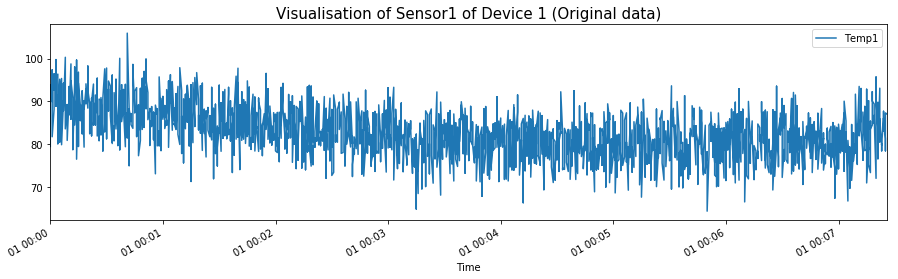

In [ ]:
#plot temperature of first sensor for df 1
dv_1.plot(x='Time', y='Temp1', figsize=(15, 4))
plt.title('Visualisation of Sensor1 of Device 1 (Original data)', size=15)

Visualise with downsampling device 1

In [ ]:
#make datetime the index
dv_1.index = dv_1['Time'] #set time column as index

Text(0.5, 1.0, 'Visualisation of Sensor1 of Device 1 (2 minutes)')

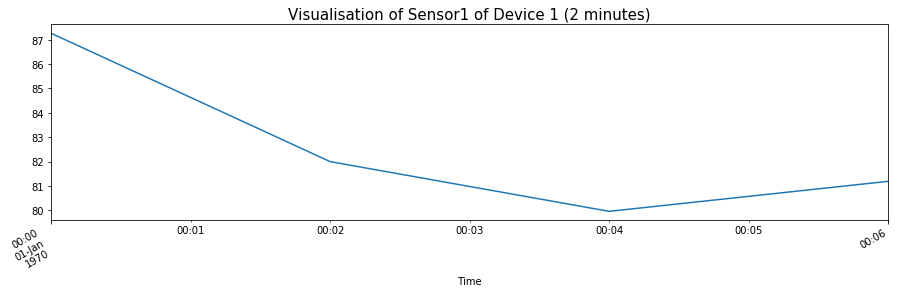

In [ ]:
dv_1["Temp1"].resample("2T").mean().plot(subplots=True, figsize=(15,4)) #visualise summary temperature of 1st sensor in 2 minute bins
plt.title('Visualisation of Sensor1 of Device 1 (2 minutes)', size=15)

In [ ]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Visualisation of Sensor1 of Device 1 (multiple)')

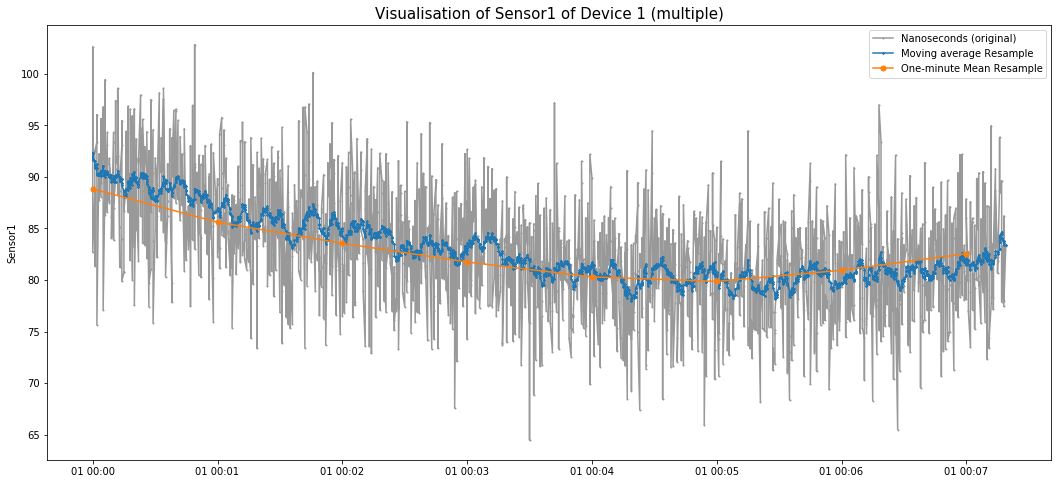

In [ ]:
#visualise Temp1 on 3 downsamplings

fig, ax = plt.subplots(figsize=(18,8))

ax.plot(dv_1["Temp1"], marker='.', markersize=2, color='0.6', linestyle=None, label='Nanoseconds (original)') 

ax.plot(dv_1["mavg_temp1"], marker='*', markersize=2, linestyle='-', label='Moving average Resample') #from earlier computation on exponential weighted average

ax.plot(dv_1["Temp1"].resample("1T").mean(), marker='o',  markersize=5, linestyle='-', label='One-minute Mean Resample')


ax.set_ylabel('Sensor1')
ax.legend()
plt.title('Visualisation of Sensor1 of Device 1 (multiple)', size=15)

The exponentially weighted moving average computed on the sensor temperatures earlier, is a good representation of the series. 

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:935: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  return gcf().gca(**kwargs)


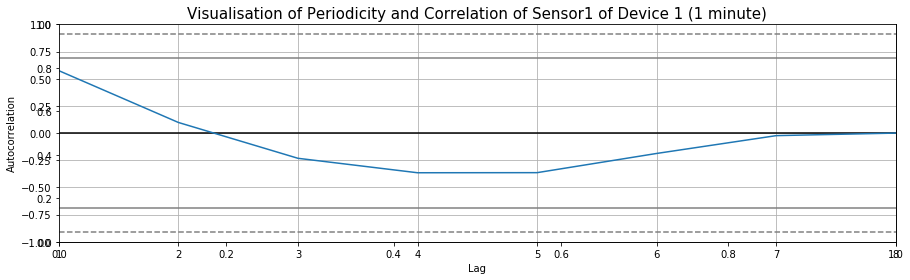

In [ ]:
#identify periodicity
fig, ax = plt.subplots(figsize=(15,4))

pd.plotting.autocorrelation_plot(dv_1["Temp1"].resample("1T").mean())

plt.title('Visualisation of Periodicity and Correlation of Sensor1 of Device 1 (1 minute)', size=15)

In [ ]:
End

In [ ]:
spark.stop()